In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import DecisionBoundaryDisplay
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
mode = 'PerGame'
trainszns = ['2015-16','2016-17','2017-18','2018-19','2020-21','2021-22','2022-23','2023-24']
stype = 'Regular+Season'
category = 'PTS'
statdf = pd.DataFrame()
for szn in trainszns:
    url = f'https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode={mode}&Scope=S&Season={szn}&SeasonType={stype}&StatCategory={category}&SeasonSegment=Pre+All-Star'
    nbd = requests.get(url)
    headers = nbd.json()['resultSet']['headers']
    szndf = pd.DataFrame(nbd.json()['resultSet']['rowSet'])
    szndf.columns = headers
    szndf['season'] = szn
    statdf = pd.concat([statdf, szndf])
statdf = statdf.rename(columns={'PLAYER': 'Name', 'season': 'Season', 'TEAM': 'Team'})

In [3]:
currszn = ['2024-25']
season = currszn[0]
url = f'https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode={mode}&Scope=S&Season={season}&SeasonType={stype}&StatCategory={category}&SeasonSegment=Pre+All-Star'
nbd = requests.get(url)
headers = nbd.json()['resultSet']['headers']
currdf = pd.DataFrame(nbd.json()['resultSet']['rowSet'])
currdf.columns = headers
currdf['season'] = season
currdf = currdf.rename(columns={'PLAYER': 'Name', 'season': 'Season', 'TEAM': 'Team'})

In [4]:
asg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Updated all stars with accents.csv')
standings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NBA Standings last nine.csv')

In [5]:
currstandings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dec 16 Standings - Sheet2.csv')
currstandings['Season'] = currszn[0]
currstandings = currstandings.dropna()

In [6]:
standings = standings.dropna()
standings['Team'] = standings['Team'].replace('PHO', 'PHX')
standings.head()

<ipython-input-6-302063cd65bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standings['Team'] = standings['Team'].replace('PHO', 'PHX')


,Season,Team,W/L%,Seed
0,2015-16,GSW,0.890,1.0
1,2016-17,GSW,0.817,1.0
2,2015-16,SAS,0.817,2.0
3,2017-18,HOU,0.793,1.0
4,2023-24,BOS,0.780,1.0


In [7]:
asg['ASG'] = 1
asg['Season'] = asg['Season'].replace('2023-2024', '2023-24')
asg.head()

,Season,Name,ASG
0,2017-18,Al Horford,1
1,2015-16,Andre Drummond,1
2,2021-22,Andrew Wiggins,1
3,2023-24,Anthony Davis,1
4,2020-21,Anthony Davis,1


In [8]:
data = statdf.merge(asg, on=['Season', 'Name'], how='left')
data = data.merge(standings, on=['Season', 'Team'], how='left')
data = data.fillna(0)
data.drop(columns = ['RANK', 'PLAYER_ID','TEAM_ID'],inplace =True)

In [9]:
currdata = currdf.merge(currstandings, on=['Season', 'Team'], how='left')
currdata = currdata.fillna(0)
currdata.drop(columns = ['RANK', 'PLAYER_ID','TEAM_ID'],inplace =True)

In [10]:
data['Season Games'] = 82
data.loc[data['Season'] == '2020-21', 'Season Games'] = 72
data['% Of Games Played'] = data['GP']/data['Season Games']
data.drop(columns = ['GP','Season Games'],inplace =True)

In [11]:
currdata['% Of Games Played'] = currdata['GP']/currdata['Season Games']
currdata.drop(columns = ['GP','Season Games'],inplace =True)

In [12]:
dataindex = []
dataindex = data['Name'] + ' '+ data['Season']
data.set_index(dataindex, inplace = True)
data.drop(columns =['Name', 'Team', 'Season'],inplace = True)

In [13]:
currdataindex = []
currdataindex = currdata['Name'] + ' '+ currdata['Season']
currdata.set_index(currdataindex, inplace = True)
currdata.drop(columns =['Name', 'Team', 'Season'],inplace = True)

In [14]:
X = data.drop(columns = 'ASG')
y = data[['ASG']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [15]:
ss = StandardScaler()
tree = DecisionTreeClassifier()
rfc = RandomForestClassifier(random_state=23)
xgb = xgb.XGBClassifier(random_state=23)

In [16]:
encoder = make_column_transformer(
    (StandardScaler(), pd.DataFrame(X).columns),
    remainder='passthrough'
)

In [17]:
rfc_pipe = Pipeline([('encoder', encoder), ('rfc', rfc)])

In [18]:
tree.fit(X_train, y_train)
rfc_pipe.fit(X_train, y_train)
xgb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=23, ...)

In [19]:
treeparams = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15]
}
treegrid = GridSearchCV(param_grid=treeparams, scoring = 'accuracy', estimator = tree)
treegrid.fit(X_train, y_train)
treetop = treegrid.best_estimator_
treepreds = treetop.predict(X_test)
treedf = pd.DataFrame(y_test)
treedf['Preds'] = treepreds
treetopascore = accuracy_score(y_test, treepreds)
print("Decision tree classifier accuracy:", treetopascore)

Decision tree classifier accuracy: 0.9526184538653366


In [20]:
rfcparams = {
    'rfc__n_estimators': [50, 100, 150],
    'rfc__max_depth': [None, 10, 20, 30],
}
rfcgrid = GridSearchCV(estimator=rfc_pipe, param_grid=rfcparams, scoring='accuracy')
rfcgrid.fit(X_train, y_train)
rfctop = rfcgrid.best_estimator_
rfcpreds = rfctop.predict(X_test)
rfcdf = pd.DataFrame(y_test)
rfcdf['Preds'] = rfcpreds
rfctopascore = accuracy_score(y_test, rfcpreds)
print("Random forest classifier accuracy:", rfctopascore)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Random forest classifier accuracy: 0.9675810473815462


In [21]:
xgbparams = {
    'max_depth': [4, 6, 8],
    'n_estimators': [100, 200, 300],
}
xgbgrid = GridSearchCV(estimator=xgb, param_grid=xgbparams, scoring='accuracy')
xgbgrid.fit(X_train, y_train)
xgbtop = xgbgrid.best_estimator_
xgbpreds = xgbtop.predict(X_test)
xgbdf = pd.DataFrame(y_test)
xgbdf['Preds'] = xgbpreds
xgbtopascore = accuracy_score(y_test, xgbpreds)
print("XGBoost classifier accuracy:", xgbtopascore)

XGBoost classifier accuracy: 0.9675810473815462


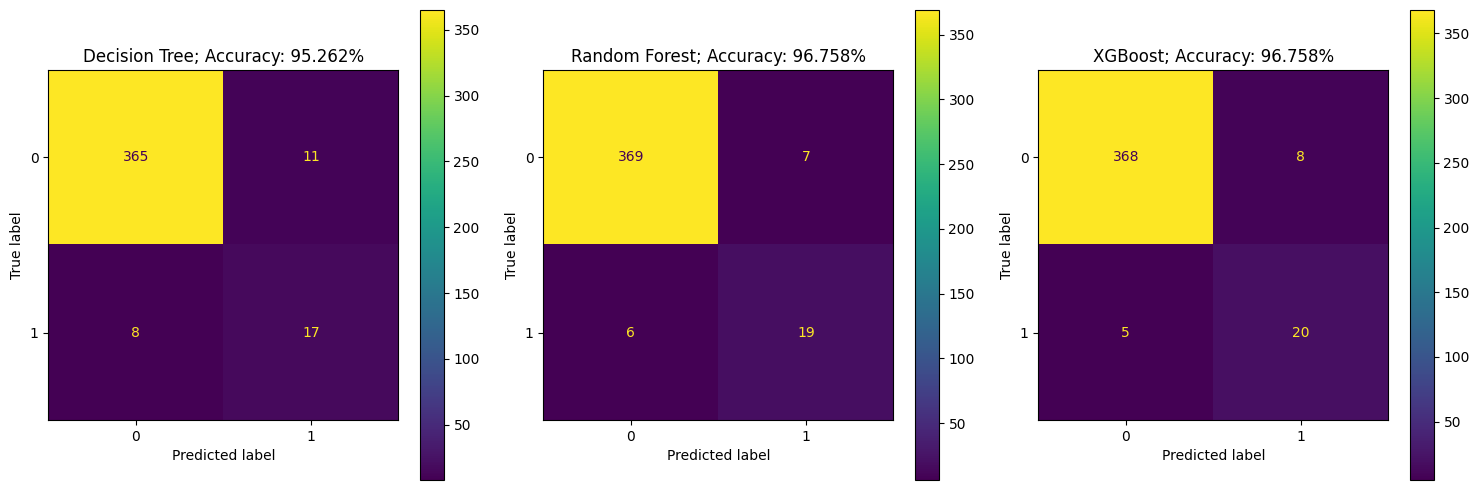

In [41]:
treecm = confusion_matrix(y_test, treepreds)
rfccm = confusion_matrix(y_test, rfcpreds)
xgbcm = confusion_matrix(y_test, xgbpreds)

titles = [f"Decision Tree; Accuracy: {treetopascore:.3%}", f"Random Forest; Accuracy: {rfctopascore:.3%}", f"XGBoost; Accuracy: {xgbtopascore:.3%}"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, cm, title in zip(axes, [treecm, rfccm, xgbcm], titles):
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot(ax=ax)
    ax.set_title(title)


plt.tight_layout()
plt.show()

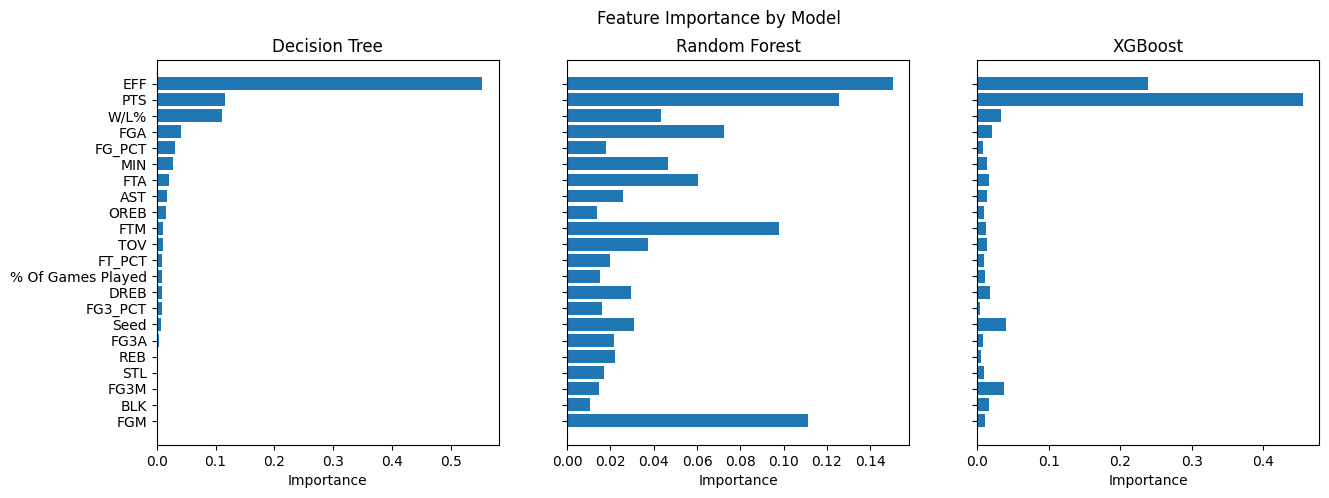

In [23]:
collist = list(X.columns)
feature_names = [f"{collist[i]}" for i in range(X.shape[1])]

treefi = treetop.feature_importances_
rfcfi = rfctop.named_steps['rfc'].feature_importances_
xgbfi = xgbtop.feature_importances_

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, importances, title in zip(
    axes,
    [treefi, rfcfi, xgbfi],
    ["Decision Tree", "Random Forest", "XGBoost"]
):
    sortindex = np.argsort(importances)
    ax.barh(np.array(feature_names)[sortindex], importances[sortindex])
    ax.set_title(title)
    ax.set_xlabel("Importance")

fig.suptitle("Feature Importance by Model")
plt.show()

In [24]:
treesnubs = treedf[(treedf['ASG'] == 0) & (treedf['Preds'] == 1)].index
treeundeserving = treedf[(treedf['ASG'] == 1) & (treedf['Preds'] == 0)].index
treesnubsdf = data.loc[treesnubs]
treeundeservingdf = data.loc[treeundeserving]

In [25]:
rfcsnubs = rfcdf[(rfcdf['ASG'] == 0) & (rfcdf['Preds'] == 1)].index
rfcundeserving = rfcdf[(rfcdf['ASG'] == 1) & (rfcdf['Preds'] == 0)].index
rfcsnubsdf = data.loc[rfcsnubs]
rfcundeservingdf = data.loc[rfcundeserving]

In [26]:
xgbsnubs = xgbdf[(xgbdf['ASG'] == 0) & (xgbdf['Preds'] == 1)].index
xgbundeserving = xgbdf[(xgbdf['ASG'] == 1) & (xgbdf['Preds'] == 0)].index
xgbsnubsdf = data.loc[xgbsnubs]
xgbundeservingdf = data.loc[xgbundeserving]

In [27]:
treesnubsdf

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,AST,STL,BLK,TOV,PTS,EFF,ASG,W/L%,Seed,% Of Games Played
Zach LaVine 2018-19,34.5,8.4,18.0,0.467,1.9,5.1,0.374,5.0,6.0,0.832,...,4.5,1.0,0.4,3.4,23.7,20.2,0.0,0.268,13.0,0.768293
Bam Adebayo 2020-21,33.5,7.1,12.5,0.570,0.0,0.1,0.250,4.4,5.5,0.799,...,5.4,1.2,1.0,2.6,18.7,26.1,0.0,0.556,6.0,0.888889
Lou Williams 2018-19,26.6,6.5,15.2,0.425,1.4,3.9,0.361,5.7,6.5,0.876,...,5.4,0.8,0.1,2.4,20.0,17.3,0.0,0.585,8.0,0.914634
Zach LaVine 2022-23,35.9,8.7,18.0,0.485,2.6,7.1,0.375,4.7,5.6,0.848,...,4.2,0.9,0.2,2.5,24.8,22.1,0.0,0.488,10.0,0.939024
Paul George 2017-18,36.6,7.3,17.0,0.430,3.1,7.7,0.401,4.3,5.2,0.822,...,3.3,2.0,0.5,2.7,21.9,20.2,0.0,0.585,4.0,0.963415
James Harden 2023-24,34.3,4.9,11.4,0.428,2.6,6.8,0.381,4.2,4.8,0.878,...,8.5,1.1,0.8,2.6,16.6,22.4,0.0,0.622,4.0,0.878049
Hassan Whiteside 2015-16,29.1,5.7,9.3,0.606,0.0,0.0,0.000,2.9,4.5,0.650,...,0.4,0.6,3.7,1.9,14.2,23.6,0.0,0.585,3.0,0.890244
Devin Booker 2020-21,33.9,9.3,19.2,0.484,1.9,5.5,0.340,5.1,5.9,0.867,...,4.3,0.8,0.2,3.1,25.6,21.3,0.0,0.708,2.0,0.930556
Pascal Siakam 2023-24,33.2,8.5,15.9,0.536,1.1,3.1,0.346,3.6,5.0,0.732,...,4.3,0.8,0.3,1.8,21.7,23.7,0.0,0.573,6.0,0.975610
James Harden 2022-23,36.8,6.4,14.5,0.441,2.8,7.2,0.385,5.4,6.2,0.867,...,10.7,1.2,0.5,3.4,21.0,27.2,0.0,0.659,3.0,0.707317


In [28]:
rfcsnubsdf

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,AST,STL,BLK,TOV,PTS,EFF,ASG,W/L%,Seed,% Of Games Played
Bam Adebayo 2020-21,33.5,7.1,12.5,0.570,0.0,0.1,0.250,4.4,5.5,0.799,...,5.4,1.2,1.0,2.6,18.7,26.1,0.0,0.556,6.0,0.888889
Zach LaVine 2022-23,35.9,8.7,18.0,0.485,2.6,7.1,0.375,4.7,5.6,0.848,...,4.2,0.9,0.2,2.5,24.8,22.1,0.0,0.488,10.0,0.939024
Paul George 2017-18,36.6,7.3,17.0,0.430,3.1,7.7,0.401,4.3,5.2,0.822,...,3.3,2.0,0.5,2.7,21.9,20.2,0.0,0.585,4.0,0.963415
James Harden 2023-24,34.3,4.9,11.4,0.428,2.6,6.8,0.381,4.2,4.8,0.878,...,8.5,1.1,0.8,2.6,16.6,22.4,0.0,0.622,4.0,0.878049
Ben Simmons 2017-18,33.7,6.7,12.3,0.545,0.0,0.1,0.000,2.4,4.2,0.560,...,8.2,1.7,0.9,3.4,15.8,23.8,0.0,0.634,3.0,0.987805
Devin Booker 2020-21,33.9,9.3,19.2,0.484,1.9,5.5,0.340,5.1,5.9,0.867,...,4.3,0.8,0.2,3.1,25.6,21.3,0.0,0.708,2.0,0.930556
James Harden 2022-23,36.8,6.4,14.5,0.441,2.8,7.2,0.385,5.4,6.2,0.867,...,10.7,1.2,0.5,3.4,21.0,27.2,0.0,0.659,3.0,0.707317


In [29]:
xgbsnubsdf

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,AST,STL,BLK,TOV,PTS,EFF,ASG,W/L%,Seed,% Of Games Played
Bam Adebayo 2020-21,33.5,7.1,12.5,0.570,0.0,0.1,0.250,4.4,5.5,0.799,...,5.4,1.2,1.0,2.6,18.7,26.1,0.0,0.556,6.0,0.888889
Zach LaVine 2022-23,35.9,8.7,18.0,0.485,2.6,7.1,0.375,4.7,5.6,0.848,...,4.2,0.9,0.2,2.5,24.8,22.1,0.0,0.488,10.0,0.939024
Paul George 2017-18,36.6,7.3,17.0,0.430,3.1,7.7,0.401,4.3,5.2,0.822,...,3.3,2.0,0.5,2.7,21.9,20.2,0.0,0.585,4.0,0.963415
James Harden 2023-24,34.3,4.9,11.4,0.428,2.6,6.8,0.381,4.2,4.8,0.878,...,8.5,1.1,0.8,2.6,16.6,22.4,0.0,0.622,4.0,0.878049
Ben Simmons 2017-18,33.7,6.7,12.3,0.545,0.0,0.1,0.000,2.4,4.2,0.560,...,8.2,1.7,0.9,3.4,15.8,23.8,0.0,0.634,3.0,0.987805
Devin Booker 2020-21,33.9,9.3,19.2,0.484,1.9,5.5,0.340,5.1,5.9,0.867,...,4.3,0.8,0.2,3.1,25.6,21.3,0.0,0.708,2.0,0.930556
James Harden 2022-23,36.8,6.4,14.5,0.441,2.8,7.2,0.385,5.4,6.2,0.867,...,10.7,1.2,0.5,3.4,21.0,27.2,0.0,0.659,3.0,0.707317
Khris Middleton 2017-18,36.4,7.2,15.5,0.466,1.8,5.0,0.359,3.9,4.4,0.884,...,4.0,1.5,0.3,2.3,20.1,20.0,0.0,0.537,7.0,1.000000


In [30]:
treeundeservingdf

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,AST,STL,BLK,TOV,PTS,EFF,ASG,W/L%,Seed,% Of Games Played
Kemba Walker 2016-17,34.7,8.1,18.3,0.444,3.0,7.6,0.399,3.8,4.5,0.847,...,5.5,1.1,0.3,2.1,23.2,20.9,1.0,0.439,11.0,0.963415
Fred VanVleet 2021-22,37.9,6.8,16.9,0.403,3.7,9.9,0.377,3.0,3.4,0.874,...,6.7,1.7,0.5,2.6,20.3,20.6,1.0,0.585,5.0,0.792683
Ben Simmons 2020-21,32.4,5.6,10.1,0.557,0.1,0.2,0.300,3.0,4.9,0.613,...,6.9,1.6,0.6,3.0,14.3,21.3,1.0,0.681,1.0,0.805556
Andrew Wiggins 2021-22,31.9,6.5,14.0,0.466,2.2,5.5,0.393,2.0,3.2,0.634,...,2.2,1.0,0.7,1.5,17.2,15.5,1.0,0.646,3.0,0.890244
Russell Westbrook 2018-19,36.0,8.6,20.2,0.428,1.6,5.6,0.290,4.1,6.2,0.656,...,10.7,1.9,0.5,4.5,22.9,29.0,1.0,0.598,6.0,0.890244
Kyrie Irving 2018-19,33.0,9.0,18.5,0.487,2.6,6.5,0.401,3.2,3.7,0.873,...,6.9,1.5,0.5,2.6,23.8,25.3,1.0,0.598,4.0,0.817073
Damian Lillard 2023-24,35.3,7.4,17.5,0.424,3.0,8.5,0.354,6.5,7.0,0.920,...,7.0,1.0,0.2,2.6,24.3,23.6,1.0,0.598,3.0,0.890244
Donovan Mitchell 2021-22,33.8,9.2,20.5,0.448,3.5,9.8,0.355,4.0,4.7,0.853,...,5.3,1.5,0.2,3.0,25.9,22.1,1.0,0.598,5.0,0.817073


In [31]:
rfcundeservingdf

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,AST,STL,BLK,TOV,PTS,EFF,ASG,W/L%,Seed,% Of Games Played
Kemba Walker 2016-17,34.7,8.1,18.3,0.444,3.0,7.6,0.399,3.8,4.5,0.847,...,5.5,1.1,0.3,2.1,23.2,20.9,1.0,0.439,11.0,0.963415
Fred VanVleet 2021-22,37.9,6.8,16.9,0.403,3.7,9.9,0.377,3.0,3.4,0.874,...,6.7,1.7,0.5,2.6,20.3,20.6,1.0,0.585,5.0,0.792683
Paolo Banchero 2023-24,35.0,8.0,17.6,0.455,1.5,4.4,0.339,5.1,7.0,0.725,...,5.4,0.9,0.6,3.1,22.6,21.7,1.0,0.573,5.0,0.975610
Ben Simmons 2020-21,32.4,5.6,10.1,0.557,0.1,0.2,0.300,3.0,4.9,0.613,...,6.9,1.6,0.6,3.0,14.3,21.3,1.0,0.681,1.0,0.805556
Andrew Wiggins 2021-22,31.9,6.5,14.0,0.466,2.2,5.5,0.393,2.0,3.2,0.634,...,2.2,1.0,0.7,1.5,17.2,15.5,1.0,0.646,3.0,0.890244
Draymond Green 2016-17,32.5,3.6,8.6,0.418,1.1,3.5,0.308,2.0,2.8,0.709,...,7.0,2.0,1.4,2.4,10.2,20.3,1.0,0.817,1.0,0.926829


In [32]:
xgbundeservingdf

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,AST,STL,BLK,TOV,PTS,EFF,ASG,W/L%,Seed,% Of Games Played
Kemba Walker 2016-17,34.7,8.1,18.3,0.444,3.0,7.6,0.399,3.8,4.5,0.847,...,5.5,1.1,0.3,2.1,23.2,20.9,1.0,0.439,11.0,0.963415
Fred VanVleet 2021-22,37.9,6.8,16.9,0.403,3.7,9.9,0.377,3.0,3.4,0.874,...,6.7,1.7,0.5,2.6,20.3,20.6,1.0,0.585,5.0,0.792683
Paolo Banchero 2023-24,35.0,8.0,17.6,0.455,1.5,4.4,0.339,5.1,7.0,0.725,...,5.4,0.9,0.6,3.1,22.6,21.7,1.0,0.573,5.0,0.975610
Kemba Walker 2018-19,34.9,8.9,20.5,0.434,3.2,8.9,0.356,4.6,5.5,0.844,...,5.9,1.2,0.4,2.6,25.6,22.5,1.0,0.476,9.0,1.000000
Andrew Wiggins 2021-22,31.9,6.5,14.0,0.466,2.2,5.5,0.393,2.0,3.2,0.634,...,2.2,1.0,0.7,1.5,17.2,15.5,1.0,0.646,3.0,0.890244


In [40]:
col_order = currdata.columns.tolist()
col_order[19], col_order[20] = col_order[20], col_order[19]

currdata = currdata[col_order]

In [34]:
treetwofivepreds = treetop.predict(currdata)
rfctwofivepreds = rfctop.predict(currdata)
xgbtwofivepreds = xgbtop.predict(currdata)

In [35]:
treetwofivedf = pd.DataFrame()
treetwofivedf['Preds'] = treetwofivepreds
treetwofivedf.index = currdata.index
rfctwofivedf = pd.DataFrame()
rfctwofivedf['Preds'] = rfctwofivepreds
rfctwofivedf.index = currdata.index
xgbtwofivedf = pd.DataFrame()
xgbtwofivedf['Preds'] = xgbtwofivepreds
xgbtwofivedf.index = currdata.index

In [36]:
asgtreedf = currdata.loc[treetwofivedf[(treetwofivedf['Preds'] == 1)].index]
asgrfcdf = currdata.loc[rfctwofivedf[(rfctwofivedf['Preds'] == 1)].index]
asgxgbdf = currdata.loc[xgbtwofivedf[(xgbtwofivedf['Preds'] == 1)].index]

In [37]:
asgtreedf

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,REB,AST,STL,BLK,TOV,PTS,EFF,W/L%,Seed,% Of Games Played
Giannis Antetokounmpo 2024-25,35.2,12.8,20.8,0.614,0.1,0.7,0.176,7.0,11.4,0.615,...,11.5,6.1,0.6,1.6,3.3,32.7,36.7,0.560000,6.0,0.920000
Nikola Jokić 2024-25,37.2,12.0,21.2,0.564,2.2,4.3,0.512,5.4,6.7,0.799,...,13.3,9.8,1.8,0.7,3.8,31.5,42.6,0.565217,5.0,0.869565
LaMelo Ball 2024-25,34.1,10.7,24.9,0.430,4.7,13.1,0.356,4.9,5.8,0.848,...,5.4,6.9,1.1,0.2,4.5,31.1,25.1,0.280000,13.0,0.720000
Shai Gilgeous-Alexander 2024-25,34.4,10.5,20.6,0.510,2.1,6.2,0.340,7.1,8.2,0.864,...,5.5,6.3,1.9,1.0,2.6,30.3,31.1,0.800000,1.0,1.000000
Luka Dončić 2024-25,37.0,10.1,21.9,0.459,3.6,10.0,0.355,5.3,6.9,0.766,...,8.6,8.2,2.1,0.5,3.5,28.9,31.3,0.653846,4.0,0.769231
Jayson Tatum 2024-25,36.4,9.3,20.4,0.453,3.8,10.5,0.359,5.9,7.4,0.802,...,9.0,5.6,1.2,0.5,2.8,28.2,29.0,0.807692,2.0,0.923077
Anthony Davis 2024-25,35.3,10.1,18.9,0.534,0.7,2.4,0.305,6.9,8.8,0.786,...,11.4,3.3,1.2,2.0,2.2,27.8,32.9,0.538462,10.0,0.961538
Anthony Edwards 2024-25,35.9,9.2,20.3,0.454,4.3,10.2,0.424,3.5,4.4,0.807,...,5.4,3.8,1.3,0.6,3.1,26.2,22.4,0.560000,7.0,1.000000
De'Aaron Fox 2024-25,37.2,9.7,20.0,0.484,2.0,6.3,0.325,4.7,5.8,0.796,...,5.1,6.1,1.7,0.3,3.5,26.1,24.2,0.500000,12.0,1.000000
Damian Lillard 2024-25,36.4,7.9,17.6,0.450,3.5,9.3,0.371,6.5,7.0,0.916,...,4.5,7.5,1.0,0.2,3.0,25.7,25.7,0.560000,6.0,0.880000


In [38]:
asgrfcdf

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,REB,AST,STL,BLK,TOV,PTS,EFF,W/L%,Seed,% Of Games Played
Giannis Antetokounmpo 2024-25,35.2,12.8,20.8,0.614,0.1,0.7,0.176,7.0,11.4,0.615,...,11.5,6.1,0.6,1.6,3.3,32.7,36.7,0.560000,6.0,0.920000
Nikola Jokić 2024-25,37.2,12.0,21.2,0.564,2.2,4.3,0.512,5.4,6.7,0.799,...,13.3,9.8,1.8,0.7,3.8,31.5,42.6,0.565217,5.0,0.869565
LaMelo Ball 2024-25,34.1,10.7,24.9,0.430,4.7,13.1,0.356,4.9,5.8,0.848,...,5.4,6.9,1.1,0.2,4.5,31.1,25.1,0.280000,13.0,0.720000
Shai Gilgeous-Alexander 2024-25,34.4,10.5,20.6,0.510,2.1,6.2,0.340,7.1,8.2,0.864,...,5.5,6.3,1.9,1.0,2.6,30.3,31.1,0.800000,1.0,1.000000
Luka Dončić 2024-25,37.0,10.1,21.9,0.459,3.6,10.0,0.355,5.3,6.9,0.766,...,8.6,8.2,2.1,0.5,3.5,28.9,31.3,0.653846,4.0,0.769231
Jayson Tatum 2024-25,36.4,9.3,20.4,0.453,3.8,10.5,0.359,5.9,7.4,0.802,...,9.0,5.6,1.2,0.5,2.8,28.2,29.0,0.807692,2.0,0.923077
Anthony Davis 2024-25,35.3,10.1,18.9,0.534,0.7,2.4,0.305,6.9,8.8,0.786,...,11.4,3.3,1.2,2.0,2.2,27.8,32.9,0.538462,10.0,0.961538
Anthony Edwards 2024-25,35.9,9.2,20.3,0.454,4.3,10.2,0.424,3.5,4.4,0.807,...,5.4,3.8,1.3,0.6,3.1,26.2,22.4,0.560000,7.0,1.000000
De'Aaron Fox 2024-25,37.2,9.7,20.0,0.484,2.0,6.3,0.325,4.7,5.8,0.796,...,5.1,6.1,1.7,0.3,3.5,26.1,24.2,0.500000,12.0,1.000000
Damian Lillard 2024-25,36.4,7.9,17.6,0.450,3.5,9.3,0.371,6.5,7.0,0.916,...,4.5,7.5,1.0,0.2,3.0,25.7,25.7,0.560000,6.0,0.880000


In [39]:
asgxgbdf

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,REB,AST,STL,BLK,TOV,PTS,EFF,W/L%,Seed,% Of Games Played
Giannis Antetokounmpo 2024-25,35.2,12.8,20.8,0.614,0.1,0.7,0.176,7.0,11.4,0.615,...,11.5,6.1,0.6,1.6,3.3,32.7,36.7,0.560000,6.0,0.920000
Nikola Jokić 2024-25,37.2,12.0,21.2,0.564,2.2,4.3,0.512,5.4,6.7,0.799,...,13.3,9.8,1.8,0.7,3.8,31.5,42.6,0.565217,5.0,0.869565
LaMelo Ball 2024-25,34.1,10.7,24.9,0.430,4.7,13.1,0.356,4.9,5.8,0.848,...,5.4,6.9,1.1,0.2,4.5,31.1,25.1,0.280000,13.0,0.720000
Shai Gilgeous-Alexander 2024-25,34.4,10.5,20.6,0.510,2.1,6.2,0.340,7.1,8.2,0.864,...,5.5,6.3,1.9,1.0,2.6,30.3,31.1,0.800000,1.0,1.000000
Luka Dončić 2024-25,37.0,10.1,21.9,0.459,3.6,10.0,0.355,5.3,6.9,0.766,...,8.6,8.2,2.1,0.5,3.5,28.9,31.3,0.653846,4.0,0.769231
Jayson Tatum 2024-25,36.4,9.3,20.4,0.453,3.8,10.5,0.359,5.9,7.4,0.802,...,9.0,5.6,1.2,0.5,2.8,28.2,29.0,0.807692,2.0,0.923077
Anthony Davis 2024-25,35.3,10.1,18.9,0.534,0.7,2.4,0.305,6.9,8.8,0.786,...,11.4,3.3,1.2,2.0,2.2,27.8,32.9,0.538462,10.0,0.961538
Anthony Edwards 2024-25,35.9,9.2,20.3,0.454,4.3,10.2,0.424,3.5,4.4,0.807,...,5.4,3.8,1.3,0.6,3.1,26.2,22.4,0.560000,7.0,1.000000
De'Aaron Fox 2024-25,37.2,9.7,20.0,0.484,2.0,6.3,0.325,4.7,5.8,0.796,...,5.1,6.1,1.7,0.3,3.5,26.1,24.2,0.500000,12.0,1.000000
Damian Lillard 2024-25,36.4,7.9,17.6,0.450,3.5,9.3,0.371,6.5,7.0,0.916,...,4.5,7.5,1.0,0.2,3.0,25.7,25.7,0.560000,6.0,0.880000
